# Region masks

### Australia state and territory mask

State boundaries from ABS: https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files

In [1]:
import xarray as xr
import geopandas
import regionmask

Load single instance of ERA5 grid
This is to be used with `regionmask` to create our mask

In [2]:
era_template = xr.open_dataset(
    "/g/data/rt52/era5/single-levels/monthly-averaged/2t/2010/2t_era5_moda_sfc_20100101-20100131.nc"
)

Load geometries

In [3]:
state_gpd = geopandas.read_file(
    "/g/data/w42/dr6273/work/data/ABS/STE_2021_AUST_SHP_GDA2020/STE_2021_AUST_GDA2020.shp"
)

In [89]:
state_gpd.head()

,STE_CODE21,STE_NAME21,CHG_FLAG21,CHG_LBL21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geometry
0,1,New South Wales,0,No change,AUS,Australia,8.007977e+05,http://linked.data.gov.au/dataset/asgsed3/STE/1,"MULTIPOLYGON (((159.06230 -31.50886, 159.06218..."
1,2,Victoria,0,No change,AUS,Australia,2.274962e+05,http://linked.data.gov.au/dataset/asgsed3/STE/2,"MULTIPOLYGON (((146.29286 -39.15778, 146.29341..."
2,3,Queensland,0,No change,AUS,Australia,1.730171e+06,http://linked.data.gov.au/dataset/asgsed3/STE/3,"MULTIPOLYGON (((142.53140 -10.68301, 142.53072..."
3,4,South Australia,0,No change,AUS,Australia,9.842314e+05,http://linked.data.gov.au/dataset/asgsed3/STE/4,"MULTIPOLYGON (((140.66025 -38.06256, 140.66006..."
4,5,Western Australia,0,No change,AUS,Australia,2.526632e+06,http://linked.data.gov.au/dataset/asgsed3/STE/5,"MULTIPOLYGON (((117.86953 -35.19108, 117.86961..."


In [90]:
list(state_gpd["STE_NAME21"])

['New South Wales',
 'Victoria',
 'Queensland',
 'South Australia',
 'Western Australia',
 'Tasmania',
 'Northern Territory',
 'Australian Capital Territory',
 'Other Territories',
 'Outside Australia']

Create mask

In [6]:
def create_mask(gpd_df, template_ds, boundary=None, lon_name='longitude', lat_name='latitude'):
    """
    Create mask from shapefiles and a template xarray dataArray or dataset.
    """
    mask = regionmask.mask_3D_geopandas(
        gpd_df,
        template_ds[lon_name],
        template_ds[lat_name]
    )
    
    if lon_name != 'lon':
        mask = mask.rename({lon_name: 'lon'})
    if lat_name != 'lat':
        mask = mask.rename({lat_name: 'lat'})
        
    if isinstance(boundary, list):
        mask = mask.sel(
            lon=slice(boundary[0], boundary[1]),
            lat=slice(boundary[2], boundary[3])
        )
        
    return mask

In [91]:
mask = create_mask(
    state_gpd.iloc[:-2],
    era_template.sel(longitude=slice(108, 158), latitude=slice(-8, -45)),
    None
)

In [92]:
mask["region"] = ["NSW", "VIC", "QLD", "SA", "WA", "TAS", "NT", "ACT"]

Combine ACT and NSW, and create a new NEM region

In [35]:
NSW2 = mask.sel(region=["NSW", "ACT"]).sum("region")

In [38]:
NEM = mask.sel(region=["NSW", "VIC", "QLD", "SA", "TAS", "ACT"]).sum("region")

In [41]:
nem_mask = xr.concat([
    mask.sel(region=["VIC", "QLD", "SA", "TAS"]),
    NSW2.expand_dims({"region": ["NSW"]}),
    NEM.expand_dims({"region": ["NEM"]})
],
    dim="region"
)

In [46]:
nem_mask = nem_mask.sel(region=["NEM", "NSW", "VIC", "QLD", "SA", "TAS"])

In [48]:
nem_mask["region"]

<xarray.DataArray 'region' (region: 6)>
array(['NEM', 'NSW', 'VIC', 'QLD', 'SA', 'TAS'], dtype=object)
Coordinates:
  * region   (region) object 'NEM' 'NSW' 'VIC' 'QLD' 'SA' 'TAS'

In [51]:
nem_mask.to_dataset(name="mask").to_netcdf("/g/data/w42/dr6273/work/projects/Aus_energy/data/NEM_state_mask.nc")

Population by state

Load population file

In [54]:
pop = xr.open_dataset(
    "/g/data/w42/dr6273/work/data/ABS/ABS_population_density/population_density_era5_grid.nc"
)["population_density"]

In [84]:
pop.sum()

<xarray.DataArray 'population_density' ()>
array(25883452., dtype=float32)

In [57]:
nem_pop = nem_mask * pop

In [88]:
nem_pop.to_dataset(name="population_density").to_netcdf(
    "/g/data/w42/dr6273/work/projects/Aus_energy/data/NEM_population_density_state_mask.nc"
)

### Europe mask

In [3]:
eu = regionmask.defined_regions.natural_earth_v5_0_0.countries_110

In [4]:
eu_template = era_template.sel(longitude=slice(-12, 30), latitude=slice(75, 35))

In [5]:
mask = eu.mask_3D(eu_template["longitude"], eu_template["latitude"])

In [6]:
mask = mask.rename({"latitude": "lat", "longitude": "lon"})

In [7]:
names = ["Austria", "Belgium", "Denmark", "France", "Germany", "Ireland", "Italy", "Luxembourg", "Netherlands",
         "Norway", "Portugal", "Spain", "Sweden", "Switzerland", "United Kingdom"]

In [8]:
mask = mask.swap_dims({"region": "names"})

In [9]:
mask = mask.sel(names=names)

In [10]:
mask = mask.sum("names")

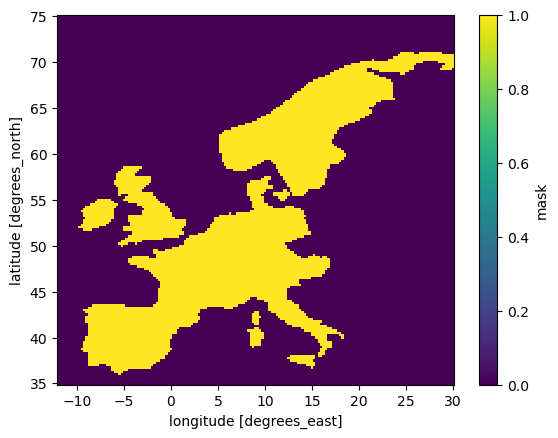

In [12]:
mask.plot()

In [13]:
mask.to_dataset(name="mask").to_netcdf("/g/data/w42/dr6273/work/projects/Aus_energy/data/EU_mask.nc")

Population by state

Load population file

In [20]:
pop = xr.open_dataset(
    "/g/data/w42/dr6273/work/data/SEDAC/population_counts_era5_grid.nc"
)["population_count"]

In [22]:
pop = pop.sel(lat=eu_template["latitude"].values, lon=eu_template["longitude"].values)

In [24]:
eu_pop = mask * pop

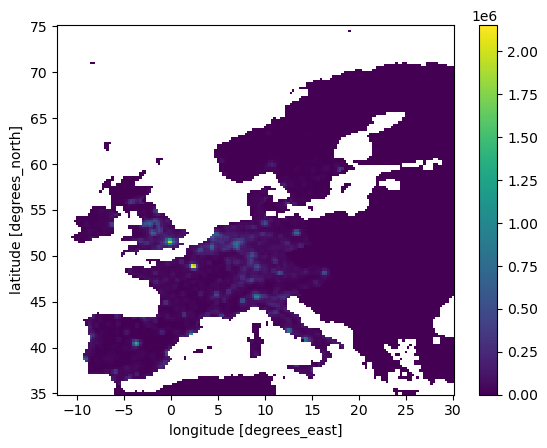

In [25]:
eu_pop.plot()

In [26]:
eu_pop.to_dataset(name="population_count").to_netcdf(
    "/g/data/w42/dr6273/work/projects/Aus_energy/data/EU_population_count_mask.nc"
)